<a href="https://cognitiveclass.ai"><img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width = 400> </a>


Welcome to exercise one of week four of “Apache Spark for Scalable Machine Learning on BigData”. In this exercise we’ll work on classification.

Let’s create our DataFrame again:


This notebook is designed to run in a IBM Watson Studio default runtime (NOT the Watson Studio Apache Spark Runtime as the default runtime with 1 vCPU is free of charge). Therefore, we install Apache Spark in local mode for test purposes only. Please don't use it in production.

In case you are facing issues, please read the following two documents first:

<https://github.com/IBM/skillsnetwork/wiki/Environment-Setup>

<https://github.com/IBM/skillsnetwork/wiki/FAQ>

Then, please feel free to ask:

[https://coursera.org/learn/machine-learning-big-data-apache-spark/discussions/all](https://coursera.org/learn/machine-learning-big-data-apache-spark/discussions/all?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-ML0201EN-SkillsNetwork-20647446&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ)

Please make sure to follow the guidelines before asking a question:

<https://github.com/IBM/skillsnetwork/wiki/FAQ#im-feeling-lost-and-confused-please-help-me>

If running outside Watson Studio, this should work as well. In case you are running in an Apache Spark context outside Watson Studio, please remove the Apache Spark setup in the first notebook cells.


In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')


In [2]:
!pip install pyspark==2.4.5

     |████████████████████████████████| 217.8 MB 11 kB/s s eta 0:00:01    |█████████▋                      | 65.6 MB 60.4 MB/s eta 0:00:03��█████████████▋    | 187.7 MB 71.9 MB/s eta 0:00:01     |████████████████████████████▌   | 194.0 MB 71.9 MB/s eta 0:00:01
     |████████████████████████████████| 197 kB 53.5 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=66522ee8584111a93adcd30be014953700e9753cdec6c89650deed5abf67b492
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/01/c0/03/1c241c9c482b647d4d99412a98a5c7f87472728ad41ae55e1e
Successfully built pyspark


In [3]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [5]:
# delete files from previous runs
!rm -f hmp.parquet*

# download the file containing the data in PARQUET format
!wget https://github.com/IBM/coursera/raw/master/hmp.parquet
    
# create a dataframe out of it
df = spark.read.parquet('hmp.parquet')

# register a corresponding query table
df.createOrReplaceTempView('df')

--2020-10-24 16:00:47--  https://github.com/IBM/coursera/raw/master/hmp.parquet
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet [following]
--2020-10-24 16:00:47--  https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet [following]
--2020-10-24 16:00:47--  https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932997 (911K) [application/octet-stream]
Savin

Since this is supervised learning, let’s split our data into train (80%) and test (20%) set.


In [6]:
splits = df.randomSplit([0.8, 0.2])
df_train = splits[0]
df_test = splits[1]

Again, we can re-use our feature engineering pipeline


In [7]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer


indexer = StringIndexer(inputCol="class", outputCol="label")

vectorAssembler = VectorAssembler(inputCols=["x","y","z"],
                                  outputCol="features")

normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)

Now we use LogisticRegression, a simple and basic linear classifier to obtain a classification performance baseline.


In [8]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
pipeline = Pipeline(stages=[indexer, vectorAssembler, normalizer,lr])
model = pipeline.fit(df_train)
prediction = model.transform(df_test)

If we look at the schema of the prediction dataframe we see that there is an additional column called prediction which contains the best guess for the class our model predicts.


In [9]:
prediction.printSchema()

root
 |-- x: integer (nullable = true)
 |-- y: integer (nullable = true)
 |-- z: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- class: string (nullable = true)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



Let’s evaluate performance by using a build-in functionality of Apache SparkML.


In [10]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
MulticlassClassificationEvaluator().setMetricName("accuracy").evaluate(prediction) 

0.2089689415931584

So we get 20% right. This is not bad for a baseline. Note that random guessing would give us only 7%. Of course we need to improve. You might have notices that we’re dealing with a time series here. And we’re not making use of that fact right now as we look at each training example only individually. But this is ok for now. More advanced courses like “Advanced Machine Learning and Signal Processing” ([https://www.coursera.org/learn/advanced-machine-learning-signal-processing/](https://www.coursera.org/learn/advanced-machine-learning-signal-processing?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-ML0201EN-SkillsNetwork-20647446&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-ML0201EN-SkillsNetwork-20647446&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ)) will teach you how to improve accuracy to the nearly 100% by using algorithms like Fourier transformation or wavelet transformation. But let’s skip this for now. In the following cell, please use the RandomForest classifier (you might need to play with the “numTrees” parameter) in the code cell below. You should get an accuracy of around 44%. More on RandomForest can be found here:

[https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier](https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-ML0201EN-SkillsNetwork-20647446&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ)


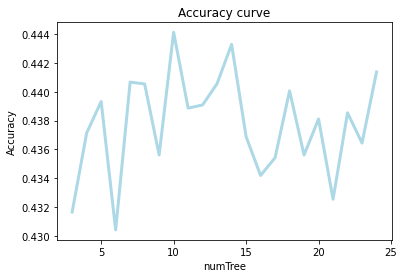

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import RandomForestClassifier

x = []
y = []
for i in range(3, 25, 1):
    rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees = i)
    pipeline = Pipeline(stages=[indexer, vectorAssembler, normalizer,rf])
    model = pipeline.fit(df_train)
    prediction = model.transform(df_test)
    ac = MulticlassClassificationEvaluator().setMetricName("accuracy").evaluate(prediction)
    #print("Accuracy " + str(i) + "= " + str(ac))
    x.append(i)
    y.append(ac)


#print("x = " + str(x))  
#print("y = " + str(y))   
plt.plot(x, y, label='accuracy' , color='lightblue', linewidth=3)
plt.ylabel('Accuracy')
plt.xlabel('numTree')
plt.title('Accuracy curve')
plt.show()

### Thank you for completing this lab!

This notebook was created by <a href="https://linkedin.com/in/romeo-kienzler-089b4557"> Romeo Kienzler </a>  I hope you found this lab interesting and educational. Feel free to contact me if you have any questions!


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                                          |
| ----------------- | ------- | ---------- | ----------------------------------------------------------- |
| 2020-09-29        | 2.0     | Srishti    | Migrated Lab to Markdown and added to course repo in GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
